# Visualization and clustering

In [111]:
#libraries

import pandas as pd
import os
import json
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import umap

#seed
SEED = 1234

## 1. Dataset preparation and visualization





Collected datasets/files:
- Million Playlist Dataset: 1000 .json files x 1000 playlists (2017)
- Scraped Playlist Dataset: 76 playlists (2025)
- Million Songs Dataset: ~1.1 mio tracks with audio features



Goal:\
to create a dataset that contains playlists from both 2017 and 2025 playlist datasets, with added audio features for each track to enable better comparisons between tracks for our recommendation system.\
\
Because Spotify Audio Features API is deprecated and data cannot be retrieved from it anymore, I have to rely on the datasets that were made before November 2024, to collect the data about tracks.\
To achieve this, a sample subset of 1000 playlists will be selected from MPD. Coverage of tracks from MSD will be calculated and playlists with a coverage above a certain treshold will be added to the subset. This will limit the amount of missing values.\
The same principle applies to the scraped PD, but I expect the treshold there to be lower, since there are not as many playlists to choose from, and it should be taken into consideration that the songs might be newer and therefore not included in the MSD that was created before their release.\
After selecting the playlists, the .json file will be converted into a .csv file and a subset of scraped playlists will be created, merged together and features added.

### 1.1 Load raw data and create subset

#### Million Song Dataset & MDS Track ID list:

In [26]:
features_df = pd.read_csv("data/_raw/spotify_data.csv")   # your 1M-song feature dataset
msd_track_ids = set(features_df["track_id"].astype(str))
len(msd_track_ids)

1159764

#### Million Playlist Dataset subset

Create a subset of sampled playlists with coverage above a certain threshold (JSON):\
Threshold of 0.75 was chosen after a few trials. It should not be too low to avoid having too many missing values, and not too high - there must be at least one playlist from each file, and we need to be careful to avoid bias, since MSD contains mostly popular songs, which woul eliminate certain playlists with more obscure tracks.

In [ ]:
# --- helper function to determine playlist coverage ---------------

def playlist_coverage(pl):

    tracks = pl.get("tracks", [])
    pl_track_ids = [track["track_uri"].split(":")[-1] for track in tracks]
    matched = sum(1 for tid in pl_track_ids if tid in msd_track_ids)

    return matched / len(pl_track_ids)
    
#---------------------------------------------------------------------


data_dir = "data/_raw/data"   #directory with 1000 MPD files
output_file = "data/mpd_sample_1000.json"

#at least 75% of tracks in a playlist must be able to get audio features from MSD
threshold = 0.75

#list of playlists that fit the criteria - 1 from each file
sampled_playlists = []

#list of files
files = sorted(os.listdir(data_dir))

for filename in files:
    filepath = os.path.join(data_dir, filename)
    #print(filename)
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
        playlists = data.get('playlists', [])

        #find the first high coverage playlist
        candidates = [pl for pl in playlists if playlist_coverage(pl) >= threshold]
        chosen = random.choice(candidates)
        sampled_playlists.append(chosen)
        #print(playlist_coverage(chosen))

#check length (should be 1000 if all files had at least 1 playlist fit the criteria)
print("Sampled playlists:", len(sampled_playlists))


#save into a new json file
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(sampled_playlists, f, indent=2)






Transform the subset of playlists to a .csv file:

In [ ]:
#read json sample file
with open("data/mpd_sample_1000.json") as f:
    data_json = json.load(f)

#a list of dictionaries (1 dict - 1 track)
rows = []

'''
example of track data: 

"pos": 0,
"artist_name": "G-Eazy",
"track_uri": "spotify:track:40YcuQysJ0KlGQTeGUosTC",
"artist_uri": "spotify:artist:02kJSzxNuaWGqwubyUba0Z",
"track_name": "Me, Myself & I",
"album_uri": "spotify:album:09Q3WwGYsQe5ognkvVkmCu",
"duration_ms": 251466,
"album_name": "When It's Dark Out"

'''

for playlist in data_json:
    playlist_id = playlist["pid"]
    playlist_name = playlist["name"]

    for track in playlist["tracks"]:
        #clean uris
        track_id = track["track_uri"].split(":")[-1]
        artist_id = track["artist_uri"].split(":")[-1]
        album_id = track["album_uri"].split(":")[-1]

        rows.append({
            "playlist_id": playlist_id,
            "playlist_name": playlist_name,
            "artist_id": artist_id,
            "artist_name": track["artist_name"],
            "track_id": track_id,
            "track_name": track["track_name"],
            "album_id": album_id,
            "album_name": track["album_name"],
            "duration_ms": track["duration_ms"],
            "position": track["pos"]
        })

df_json = pd.DataFrame(rows)
df_json.to_csv("data/mpd_playlists.csv", index=False)

df_json.sample(n=5)

,playlist_id,playlist_name,artist_id,artist_name,track_id,track_name,album_id,album_name,duration_ms,position
29296,958367,my music,1URnnhqYAYcrqrcwql10ft,21 Savage,3xAXYCtd98G5G0SSJAHtqd,Dip Dip,1HSyuTHvLXMWyPJQGnQTLw,Slaughter King,151614,19
30460,985579,Rock,2zgG1GPDvjaBgxeQaVXI14,All That Remains,0jfUcioASffFKqdgaDGnKU,Dead Wrong,265S1PnneYr8bc7LH3wxxt,For We Are Many,187053,31
21997,746053,Rap Caviar,3TVXtAsR1Inumwj472S9r4,Drake,7sBwAWyXfiIgrYQ8BaJESH,Keep The Family Close,40GMAhriYJRO1rsY4YdrZb,Views,328906,8
30559,985579,Rock,56dO9zeHKuU5Gvfc2kxHNw,Chevelle,2Bcvh4zypRuH0cCTQzuV6B,Don't Fake This,481JiVXZYUlTtqlv9ewJXV,Wonder What's Next,219066,130
10237,398610,Wedding Songs,0s1ec6aPpRZ4DCj15w1EFg,Dario Marianelli,0EHJOhOakEiobXo81vegdy,"Dawn - From ""Pride & Prejudice"" Soundtrack",31qEnY1MFmGwOdgjLLClPd,Pride and Prejudice OST,158600,1


#### Scraped Dataset subset

Check coverage:

In [ ]:
#read file
scraped = pd.read_csv("data/_raw/scraped/spotify_tracks.csv")

#mask column: is each track present in msd
scraped['in_msd'] = scraped['track_id'].apply(lambda x: x in msd_track_ids)

#coverage portion of playlist
coverage_df = (
    scraped.groupby('playlist_id')['in_msd']
           .agg(['sum', 'count'])
           .reset_index()
)

#average per playlist
coverage_df['coverage'] = coverage_df['sum'] / coverage_df['count']

#check range
print("Best coverage: ", np.max(coverage_df['coverage']))
print("Mean coverage: ", np.mean(coverage_df['coverage']))


Best coverage:  0.6507936507936508
Mean coverage:  0.14339813567913973


The coverage of scaped data by MSD is significantly lower than with the MPD. That is because this data is newer and contains songs that were released after MSD was already made, and because scraped data contains only 76 playlists, which is very little to pick from.\
After a few trials I decided on a threshold of 0.15, which is a little bit above average and eliminates the worst 2/3 of the data.


In [ ]:
threshold = 0.15

#get ids of good playlists
good_ids = coverage_df[coverage_df['coverage'] >= threshold]['playlist_id']
print(len(good_ids))

#filter and keep good playlists
scraped_filtered = scraped[scraped['playlist_id'].isin(good_ids)]

#drop mask column
scraped_filtered = scraped_filtered.drop(columns=('in_msd'))

#save new subset to csv
scraped_filtered.to_csv("data/scraped_filtered.csv", index=False)

26


#### Merge both subsets 

In [32]:
#read files
scraped_subset = pd.read_csv("data/scraped_filtered.csv")
mpd_subset = pd.read_csv("data/mpd_playlists.csv")

#rename to fit mpd column
scraped_subset = scraped_subset.rename(columns={"artists": "artist_name"})

#combine
df_all = pd.concat([scraped_subset, mpd_subset], ignore_index=True)

#fix dtype conflict
df_all['playlist_id'] = df_all['playlist_id'].astype(str)

#save
df_all.to_csv("data/combined_data.csv")

df_all.sample(n=10)

,genre,playlist_id,playlist_name,track_id,track_name,artist_name,artist_id,album_id,album_name,duration_ms,position
6618,rock,7DgPQwzEoUVfQYBiMLER9Z,Top 100 Most Popular Rock Songs,6kvoHl80mfCVTv7XnZkjQn,"It Must Have Been Love - From the Film ""Pretty...",Roxette,NaN,NaN,NaN,NaN,NaN
5840,hip hop,6WpR9aAng5hosMVyoZBlUR,Det fandme hip hop!,3awiJv0t7PebSJBwmpYqrE,Hvem Er Du?,NaN,NaN,NaN,NaN,NaN,NaN
3756,hip hop,0dMexqq0XIWS3QJ74z3ZhD,Hip Hop 2000s Music - Best Hip Hop Hits of the...,02qO38tLXcbfwoEiDP7CbH,Until The End Of Time,NaN,NaN,NaN,NaN,NaN,NaN
13161,NaN,102580,country,4wFUdSCer8bdQsrp1M90sa,Highway Don't Care,Tim McGraw,6roFdX1y5BYSbp60OTJWMd,1O3BsjGx9plSOJ036ZY4Fl,Two Lanes Of Freedom,276880.0,29.0
16589,NaN,201212,holi,0N1ovA3XHl8JmkaprmyQ9I,Issues,Escape the Fate,5ojhEavq6altxW8fWIlLum,0Nx73WC8U3K1OzIj5yL73G,Escape The Fate,161973.0,49.0
39823,NaN,880875,Heavy,4y1euCnBLwNXAhqc9vENxX,Time and Tide,For Today,3xvHWAD1Bz6vvVmVMPpZJs,0EWUY9ant2nzDm5OV7eET4,Wake,201573.0,37.0
8198,pop,7xkmRjcU7adwvRRtdHCLGr,pop girlies💞🪩🥂,6Uy6K3KdmUdAfelUp0SeXn,Brave,Sara Bareilles,NaN,NaN,NaN,NaN,NaN
40402,NaN,895488,Wiz,3fLkVBQOk72E64f4pQR1PL,Wake Up,Wiz Khalifa,137W8MRPWKqSmrBGDBFSop,6ZOXiVL8rmk2ATHJiFJhiD,Rolling Papers,226840.0,48.0
233,rock,29fOXPbR3qClySksICQ2Yn,ROCK MUSIK,7rSERmjAT38lC5QhJ8hnQc,I'm Shipping Up To Boston,NaN,NaN,NaN,NaN,NaN,NaN
35427,NaN,757588,hippity hop,1WoOzgvz6CgH4pX6a1RKGp,My Way (feat. Monty),Fetty Wap,6PXS4YHDkKvl1wkIl4V8DL,2gKQvajkEEaDtkqJ8FJ4uw,Fetty Wap,213053.0,27.0


#### Add the MSD data:
For the overlapping columns the data from playlist datasets has priority.

In [35]:
features_df = pd.read_csv("data/_raw/spotify_data.csv")
df_all = pd.read_csv("data/combined_data.csv")

#column names check
print(features_df.columns)
print(df_all.columns)

#drop index column
features_df = features_df.drop(columns="Unnamed: 0")
df_all = df_all.drop(columns="Unnamed: 0")

Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')
Index(['Unnamed: 0', 'genre', 'playlist_id', 'playlist_name', 'track_id',
       'track_name', 'artist_name', 'artist_id', 'album_id', 'album_name',
       'duration_ms', 'position'],
      dtype='object')


In [66]:
#merge based on track id
merged = df_all.merge(
    features_df,
    on="track_id",
    how="left",
    suffixes=("", "_feat")
)

#filling NAs with info from features df
feat_cols = [c for c in merged.columns if c.endswith("_feat")]
for f in feat_cols:
    base = f[:-5]
    merged[base] = merged[base].fillna(merged[f])

#removing duplicated features
merged = merged.drop(columns=feat_cols)

#added this later - replace genre "hip hop" with "hip-hop"
merged['genre'] = merged['genre'].replace("hip hop", "hip-hop")

merged.to_csv("data/merged_with_features.csv", index=False)

merged.sample(n=10)

,genre,playlist_id,playlist_name,track_id,track_name,artist_name,artist_id,album_id,album_name,duration_ms,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
15596,hip-hop,174604,2016,5hTpBe8h35rJ67eAWHQsJx,Caroline,Aminé,3Gm5F95VdRxW3mqCn8RPBJ,3lajefIuUk4SfzqVBSJy8p,Good For You,209640.0,...,5.0,-10.179,0.0,0.5050,0.170000,0.000000,0.2620,0.7070,120.040,4.0
20625,rock,313490,Road Trip Songs,2hgkutEHVmJRg7drAJAFHi,Camisado,Panic! At The Disco,20JZFwl6HVl6yg8a4H3ZqK,2YeOhhJg3OWpN0F1VYPxtW,A Fever You Can't Sweat Out,191866.0,...,2.0,-3.493,1.0,0.1380,0.017700,0.000000,0.1150,0.4090,156.076,4.0
17858,dance,235108,race day,1uXbwHHfgsXcUKfSZw5ZJ0,Run the World (Girls),Beyoncé,6vWDO969PvNqNYHIOW5v0m,1gIC63gC3B7o7FfpPACZQJ,4,236093.0,...,0.0,-4.237,1.0,0.1430,0.004960,0.000046,0.3720,0.7590,127.091,4.0
40624,NaN,901647,Ska,7ADSDc678L8af5xOVcaTG1,Everything Sucks - Best Of,Reel Big Fish,3bXhZFreBJF4QDUUiMmtZW,1U7jVocQwP0iF7eQP0wmUI,The Best Of Us For The Rest Of Us,174426.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43836,NaN,990070,Nope,2QjOHCTQ1Jl3zawyYOpxh6,Sweater Weather,The Neighbourhood,77SW9BnxLY8rJ0RciFqkHh,4xkM0BwLM9H2IUcbYzpcBI,I Love You.,240400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14623,german,144792,Renee,6X0zGq2nWueSyc1JvZOd2K,The Kraken - Score,Hans Zimmer,0YC192cP3KPCRWx8zr8MfZ,5eQEdvd6pq0uo2pQa56aUH,Pirates of the Caribbean: Dead Man's Chest,413933.0,...,2.0,-13.318,1.0,0.0407,0.085300,0.916000,0.0994,0.0636,179.953,4.0
11464,hip-hop,6sO08GSiuU7cGlvQmTE81g,Hiphop Træningsmusik (opdateres hver onsdag),5XvAhgPhiKjWYuT1xdSlP8,"What You Sayin' (feat. Styles P., Masspike Mil...",J. Cardim,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30876,alt-rock,625136,Toby Mac,7rh66kkZgNeZPFywGHaj4C,Favorite Song - feat. Jamie Grace,tobyMac,5VX8hxrcfJWwaTLiqGUHG3,31vtzv0S08tqIUnxTOcDkV,Eye On It,236559.0,...,11.0,-4.034,1.0,0.0402,0.067700,0.000000,0.0536,0.9470,103.036,4.0
11758,hip-hop,6WpR9aAng5hosMVyoZBlUR,Det fandme hip hop!,2mYnMZOESVQeUcbvxR1lYi,AmeriKKKa's Most Wanted,Ice Cube,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25273,rock,45842,pls,0zewUY3RSh8yaV7q66Okem,Vegas Lights,Panic! At The Disco,20JZFwl6HVl6yg8a4H3ZqK,1hxraaWEf3wFnJxADf8Dge,"Too Weird To Live, Too Rare To Die!",189106.0,...,5.0,-5.987,1.0,0.0449,0.000433,0.000000,0.3310,0.8340,123.960,4.0


### 1.2 Exploratory data analysis of the sampled data set 

In [5]:
#load sampled data set
df = pd.read_csv("data/merged_with_features.csv", low_memory=False)

#### Number of playlists, tracks, artists, genres: 

In [71]:

print(f"Number of rows: {len(df)}")

playlist_col = "playlist_id"
track_col    = "track_id"
artist_col   = "artist_id"
genre_col = "genre"

print(f"Number of unique playlists: {df[playlist_col].nunique()}")
print(f"Number of unique tracks: {df[track_col].nunique()}")
print(f"Number of unique artists: {df[artist_col].nunique()}")
print(f"Number of genres: {df[genre_col].nunique()}")


Number of rows: 44097
Number of unique playlists: 1026
Number of unique tracks: 16409
Number of unique artists: 1768
Number of genres: 57


In [72]:
df[genre_col].unique()

array(['rock', 'pop', 'hip-hop', 'country', nan, 'hardcore', 'metal',
       'alt-rock', 'k-pop', 'dance', 'edm', 'house', 'dub', 'chill',
       'swedish', 'classical', 'singer-songwriter', 'emo', 'german',
       'piano', 'hard-rock', 'blues', 'electro', 'soul', 'jazz',
       'show-tunes', 'funk', 'indie-pop', 'french', 'club', 'acoustic',
       'metalcore', 'trance', 'new-age', 'folk', 'electronic', 'goth',
       'sad', 'comedy', 'opera', 'punk-rock', 'punk', 'garage',
       'songwriter', 'deep-house', 'disco', 'ambient', 'spanish',
       'industrial', 'sleep', 'death-metal', 'black-metal', 'dubstep',
       'ska', 'gospel', 'indian', 'progressive-house', 'guitar'],
      dtype=object)

#### Missing value distribution and handling:

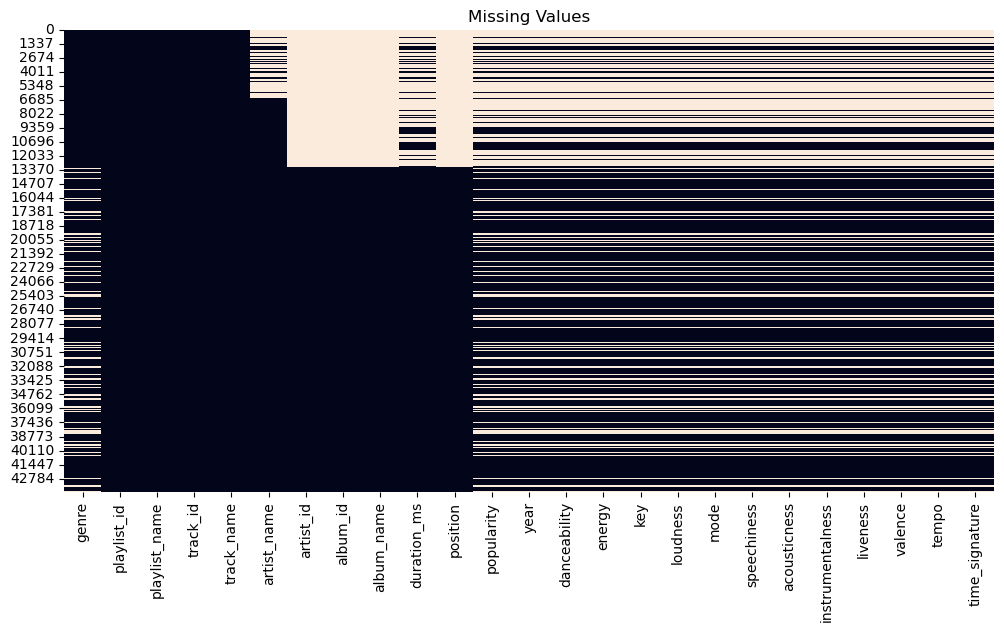

                  missing_count  missing_percent
year                      14924            33.84
danceability              14924            33.84
tempo                     14924            33.84
valence                   14924            33.84
liveness                  14924            33.84
instrumentalness          14924            33.84
acousticness              14924            33.84
speechiness               14924            33.84
mode                      14924            33.84
loudness                  14924            33.84
key                       14924            33.84
energy                    14924            33.84
time_signature            14924            33.84
popularity                14924            33.84
position                  13050            29.59
album_name                13050            29.59
album_id                  13050            29.59
artist_id                 13050            29.59
duration_ms                8869            20.11
genre               

In [68]:
missing_count = df.isna().sum()
missing_percent = df.isna().mean() * 100

missing_summary = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percent": missing_percent.round(2)
}).sort_values("missing_percent", ascending=False)

def plot_missing_values(df, title="Missing Values"):
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isna(), cbar=False)
    plt.title(title)
    plt.show()

plot_missing_values(df)
print(missing_summary)

Approximately 33% of all tracks are missing every audio feature.\
Since these features are essential for PCA and clustering, I will proceed with two parallel strategies:

**Dropping Missing-Feature Tracks**\
A second dataset will be created by removing all tracks that lack audio features entirely, ensuring a fully complete dataset for comparison.


**Per-Genre Imputation**\
To preserve as much data as possible, missing audio features will be imputed using the median value within each genre.\
If a track has no valid genre label, the most common genre within its playlist will be used as a fallback.


\
Almost 14% of the tracks are missing genre as well. Since genre information is able to come from either dataset (playlist subset or MSD), it can be assumed that tracks who lack genre lack audio features as well.\
After dropping Missing-Feature tracks, all tracks should have genre.\
Before per-genre imputation, missing values will be filled with the mode genre of the track's playlist.




#### Summary statistics for audio features:

In [53]:
#list of audio features
audio_features = [
    'danceability', 'energy', 'key',
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

#check if all are numerical
df[audio_features].dtypes

#summary statistics
summary_stats = df[audio_features].agg(["mean", "median", "std"]).T
print(summary_stats)

                        mean    median        std
danceability        0.614647    0.6130   0.154966
energy              0.678184    0.7050   0.193592
key                 5.227676    5.0000   3.626954
loudness           -6.454428   -5.8960   3.167930
mode                0.659000    1.0000   0.474054
speechiness         0.122717    0.0598   0.125361
acousticness        0.179441    0.0793   0.229646
instrumentalness    0.028085    0.0000   0.139306
liveness            0.200827    0.1350   0.160161
valence             0.476291    0.4700   0.225205
tempo             124.459921  124.7830  29.896048


Correlation heatmap of audio features:

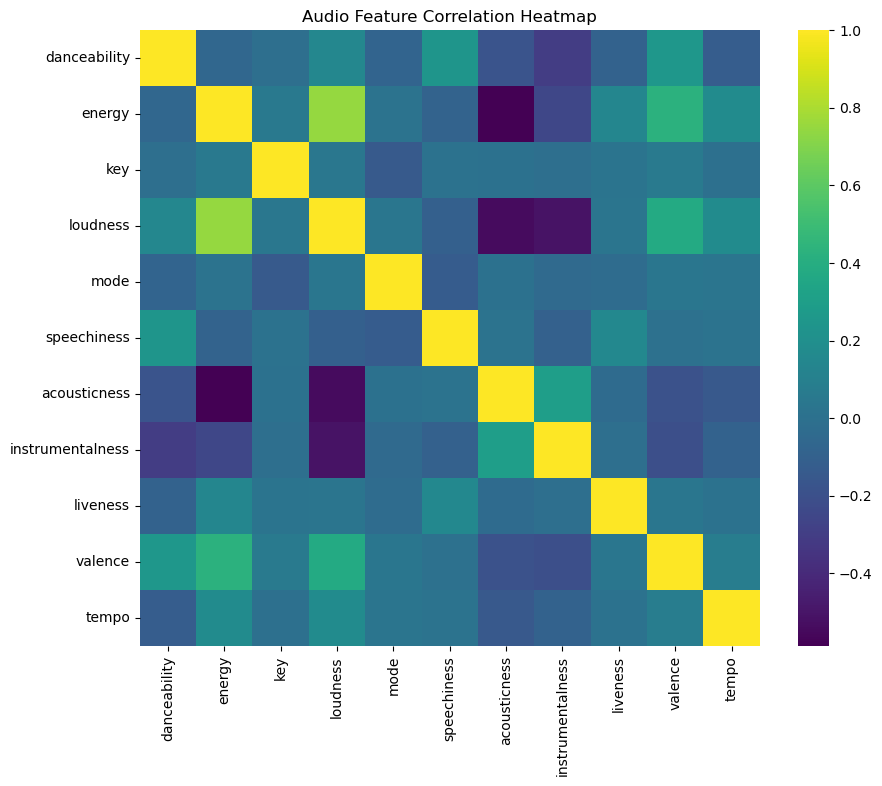

In [58]:
def plot_audio_correlations(df, audio_cols):
    plt.figure(figsize=(10,8))
    corr = df[audio_cols].corr()
    sns.heatmap(corr, cmap="viridis", annot=False)
    plt.title("Audio Feature Correlation Heatmap")
    plt.show()

plot_audio_correlations(df, audio_features)

Distribution plots for audio features:

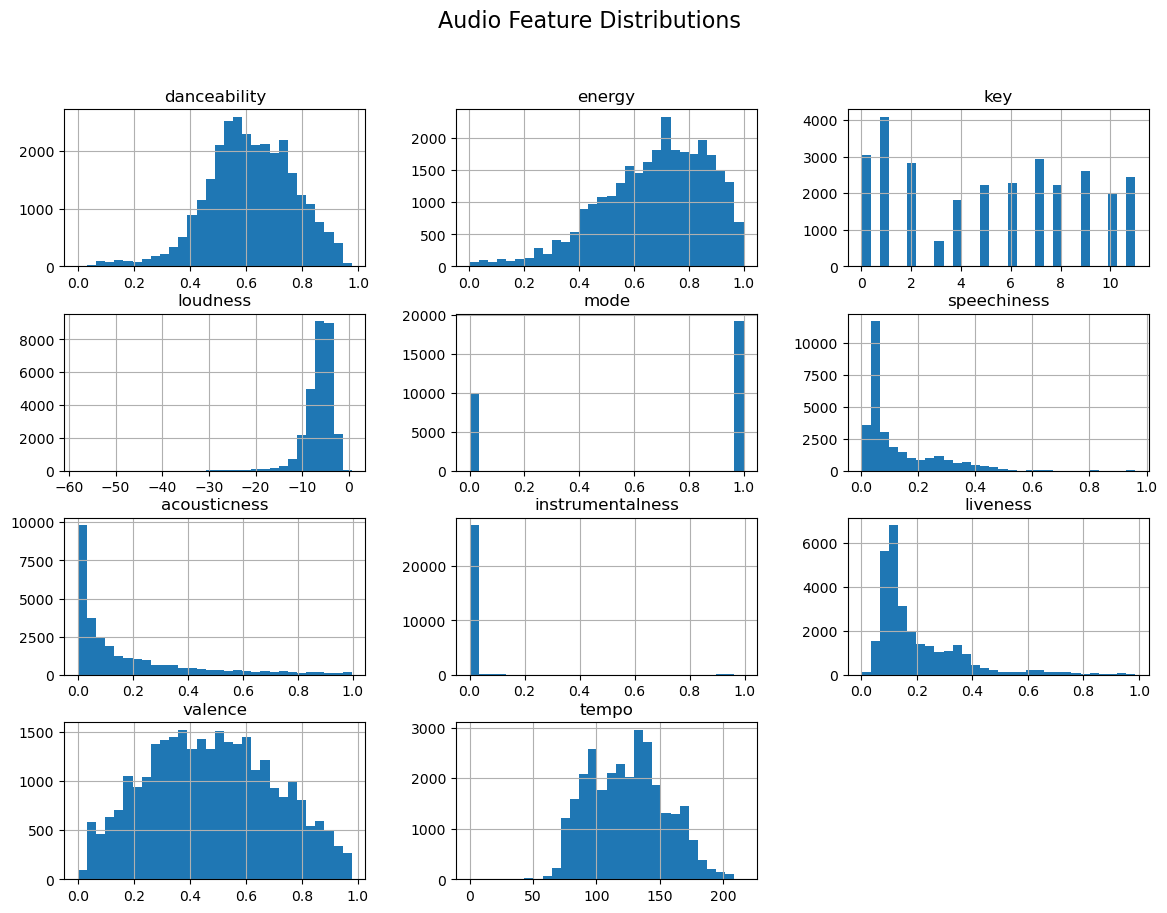

In [59]:
def plot_audio_distributions(df, audio_cols):
    df[audio_cols].hist(figsize=(14,10), bins=30)
    plt.suptitle("Audio Feature Distributions", fontsize=16)
    plt.show()

plot_audio_distributions(df, audio_features)

#### Genre distribution

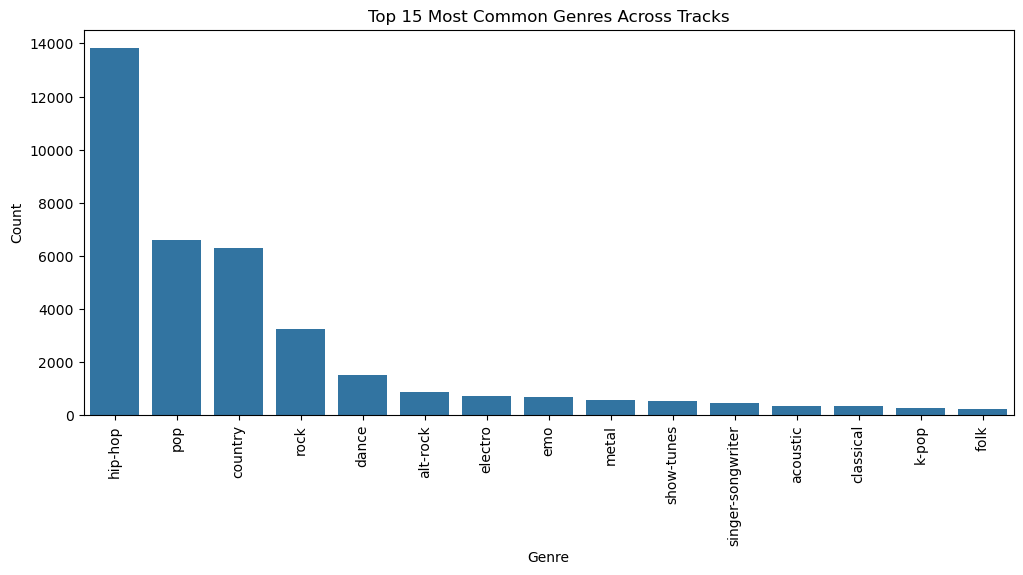

In [70]:
def plot_top_genres(df, n=15):
    plt.figure(figsize=(12, 5))

    #get top n genres
    top = df['genre'].value_counts().head(n).index

    sns.countplot(
        data= df[df['genre'].isin(top)],
        x='genre',
        order=top
    )

    plt.xticks(rotation=90)
    plt.title(f"Top {n} Most Common Genres Across Tracks")
    plt.xlabel("Genre")
    plt.ylabel("Count")
    plt.show()

plot_top_genres(df, 15)

This shows that sampled data is very biased, which will likely affect clustering and further analysis. This happened because MSD covers mainly hip-hop and popular tracks.\
Hip-hop accounts for more than 1/3 of the data.\
To fix this, genres will be normalized at playlist level, which will hopefully enable playlist composition to be presented in the clusters.

Another option would be to downsample hip-hop tracks for clustering. However, that is not a realistic approach for building a recommender.

#### Playlist titles statistics

Playlist name lengths:

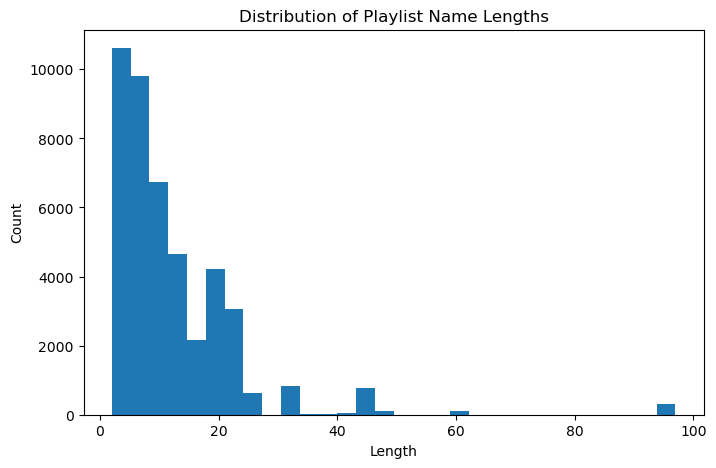

In [74]:
def plot_playlist_name_lengths(df):
    lengths = df['playlist_name'].apply(len)
    plt.figure(figsize=(8,5))
    plt.hist(lengths, bins=30)
    plt.title("Distribution of Playlist Name Lengths")
    plt.xlabel("Length")
    plt.ylabel("Count")
    plt.show()

plot_playlist_name_lengths(df)

Common playlist title words:

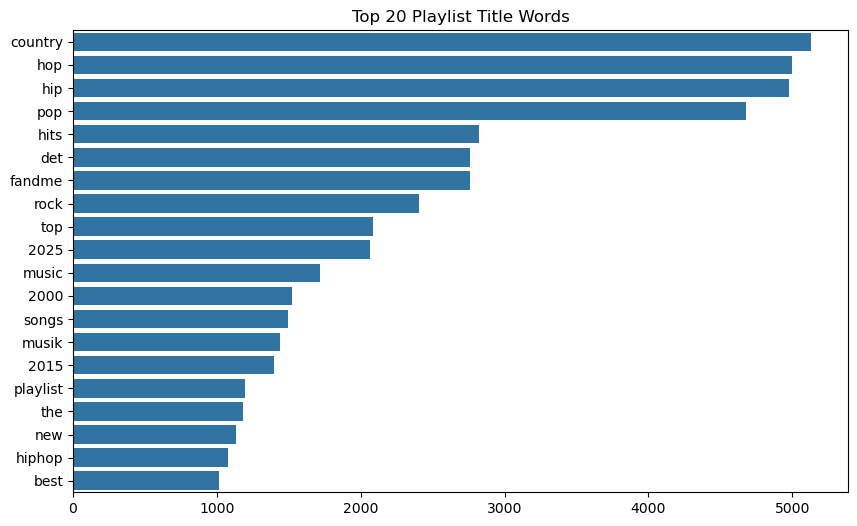

In [6]:
def plot_common_playlist_words(df, n=20):
    names = df['playlist_name'].dropna().str.lower()
    words = re.findall(r'\w+', " ".join(names))
    
    counter = Counter(words)
    most = counter.most_common(n)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=[c[1] for c in most], y=[c[0] for c in most])
    plt.title(f"Top {n} Playlist Title Words")
    plt.show()

plot_common_playlist_words(df, 20)

Common artists:

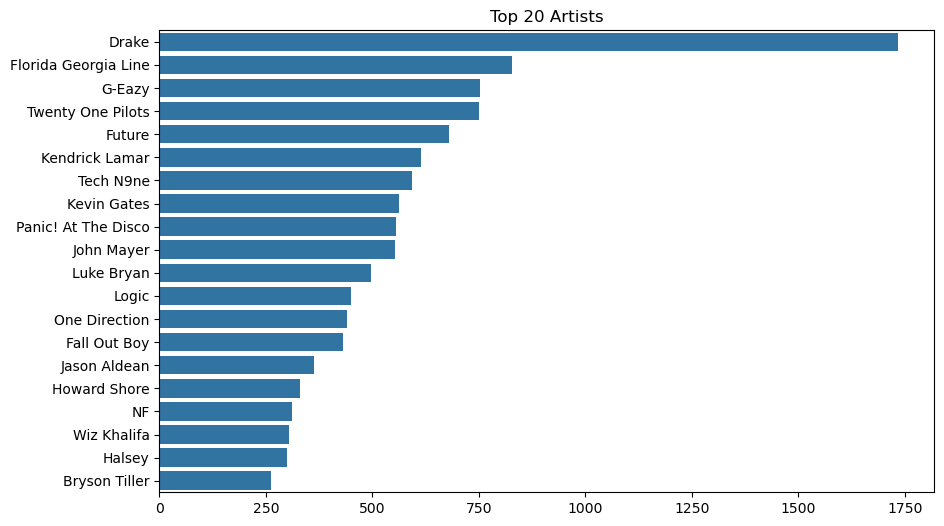

In [9]:
def plot_common_artists(df, n=20):
    artists = df['artist_name'].dropna()
    counter = Counter(artists)
    most = counter.most_common(n)

    plt.figure(figsize=(10,6))
    sns.barplot(x=[c[1] for c in most], y=[c[0] for c in most])
    plt.title(f"Top {n} Artists")
    plt.show()

plot_common_artists(df, 20)

### 1.3 The three analysis datasets

#### Dataset with dropped NAs

In [86]:
def create_dropna_dataset(df, cols, audio_features):
    df = df[cols]
    return df.dropna(subset=cols).copy()

cols = ['playlist_id', 'genre'] + audio_features
df_drop = create_dropna_dataset(df, cols, audio_features)

df_drop.to_csv("data/data_audio_dropped.csv")


#### Dataset with imputed values (per-genre)

In [10]:
#calculating global medians
global_medians = {}

#select only genre + audio columns
audio_df = df[cols]

for c in audio_features:
    med = audio_df[c].median(skipna=True)
    global_medians[c] = med

#print(global_medians)

#calculating per-genre medians
genres = audio_df['genre'].unique()
genre_medians = audio_df.groupby('genre')[audio_features].median()

#print(genre_medians.sample(n=5))

#find mode of genre per playlist and fill missing genre values
num_missing_genre = audio_df['genre'].isna().sum()
#print(num_missing_genre)

playlist_genre_mode = (audio_df.groupby('playlist_id')['genre'].agg(lambda x: x.mode()[0]))
#print(playlist_genre_mode.sample(n=5))

#fill missing genres in tracks
df_imp = audio_df.merge(playlist_genre_mode.rename("playlist_genre"), 
                    on="playlist_id", how='left')
df_imp['genre'] = df_imp['genre'].fillna(df_imp['playlist_genre'])
df_imp = df_imp.drop(columns=['playlist_genre'])
#df_imp.sample(n=5)

#fill missing audio features in tracks based on genre
for c in audio_features:
    df_imp[c] = df_imp[c].fillna(
        df_imp['genre'].map(genre_medians[c])
    )

#verify no missing values
df_imp.isna().sum().sum()

df_imp.to_csv("data/data_audio_imputed.csv")

NameError: name 'cols' is not defined

#### Dataset with text

In [94]:
df.columns
text_cols = ['playlist_id', 'playlist_name', 'track_name', 'artist_name', 'album_name'] 
df_text = df[text_cols]
df_text.to_csv("data/data_text.csv")

#### 1.4 Per-playlist feature aggregation:

Audio + genre:

In [13]:
#PLAYLIST-LEVEL FEATURE AGGREGATION
def aggregate_playlists(df):
    
    playlist_id = "playlist_id"
    track_id = "track_id"
    num_audio_cols = ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']
    genre = "genre"
    
    #numeric aggregation
    mean_df = df.groupby(playlist_id)[num_audio_cols].mean()
    mean_df.columns = [f"{c}_mean" for c in mean_df.columns]
    
    #genre proportion in a playlist: one-out-of-K encoding
    genre_dummies = pd.get_dummies(df[genre], prefix="genre")
    genre_df = pd.concat([df[[playlist_id]], genre_dummies], axis=1)
    genre_props = genre_df.groupby(playlist_id).mean()

    #print(genre_props.sample(n=5))

    #join
    playlist_features = (
        mean_df
        .join(genre_props, how="left")
    )

    #print(playlist_features.columns)

    return playlist_features

df_imp = pd.read_csv("data/data_audio_imputed.csv")
df_drop = pd.read_csv("data/data_audio_dropped.csv")

aggr_imp = aggregate_playlists(df_imp)
aggr_drop = aggregate_playlists(df_drop)

aggr_imp.to_csv("data/audio_imputed_aggr.csv")
aggr_drop.to_csv("data/audio_dropped_aggr.csv")

aggr_imp.sample(n=5)


,danceability_mean,energy_mean,key_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,instrumentalness_mean,liveness_mean,valence_mean,...,genre_sad,genre_show-tunes,genre_singer-songwriter,genre_ska,genre_sleep,genre_songwriter,genre_soul,genre_spanish,genre_swedish,genre_trance
playlist_id,,,,,,,,,,,,,,,,,,,,,
928914,0.525167,0.705500,8.333333,-5.762417,0.833333,0.040525,0.219086,0.000006,0.131767,0.511667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
797502,0.705342,0.583579,5.631579,-6.551632,0.736842,0.096842,0.295827,0.000562,0.151121,0.491684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.894737,0.0,0.0,0.0
168449,0.564824,0.787235,6.176471,-5.050235,0.882353,0.038718,0.139759,0.000008,0.146788,0.591882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
223967,0.647381,0.538857,4.523810,-7.918810,0.857143,0.141590,0.336296,0.002295,0.171210,0.408562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
141888,0.779143,0.610190,5.952381,-6.557238,0.619048,0.168519,0.145144,0.007730,0.150652,0.344419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## 2. Clustering

### 2.1 Audio based clustering

Clustering based on audio features will be done in parallel with both the imputed and the dropped NAs version of the data sets. At the end results will be evaluated based on which data set performs better and yields more reasonable results.

#### Preparation

Load data:

In [6]:
df_imp_all = pd.read_csv("data/audio_imputed_aggr.csv")
df_drop_all = pd.read_csv("data/audio_dropped_aggr.csv")

#remove columns with genre - need only audio features for this clustering
genre_cols = [col for col in df_imp_all.columns if col.startswith("genre_")]
df_imp = df_imp_all.drop(columns=genre_cols)
df_drop = df_drop_all.drop(columns=genre_cols)


df_imp.sample(n=5, random_state=SEED)

,playlist_id,danceability_mean,energy_mean,key_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,instrumentalness_mean,liveness_mean,valence_mean,tempo_mean
803,800343,0.540179,0.711036,5.428571,-5.802607,0.964286,0.035525,0.117368,0.000229,0.181000,0.500375,129.501554
523,56120,0.713360,0.518320,4.280000,-7.159480,0.520000,0.160872,0.315436,0.001218,0.121884,0.576640,118.729240
89,180374,0.526875,0.746750,6.125000,-6.965250,1.000000,0.066587,0.069895,0.017694,0.166237,0.334425,134.630625
916,901647,0.549080,0.885973,5.451327,-3.569248,0.761062,0.088474,0.056431,0.003890,0.226073,0.694509,123.450796
270,336665,0.672159,0.666750,5.840909,-4.504545,0.863636,0.037873,0.139348,0.000591,0.109700,0.632250,120.865886


Scaling:

In [7]:
def scale_features(df, feature_cols):

    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df[feature_cols])
    
    #array -> df
    df_scaled = pd.DataFrame(scaled_array, 
                             columns=feature_cols, 
                             index=df.index)
    
    #make a scaled full df
    df_scaled_full = pd.concat([df.drop(columns=feature_cols), df_scaled], axis=1)
    
    return df_scaled_full

cols = df_drop.columns[1:].to_list()
df_imp_scaled = scale_features(df_imp, cols)
df_drop_scaled = scale_features(df_drop, cols)

df_imp_scaled.sample(n=5, random_state=SEED)

,playlist_id,danceability_mean,energy_mean,key_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,instrumentalness_mean,liveness_mean,valence_mean,tempo_mean
803,800343,-0.846230,0.380546,0.240996,0.329010,1.416319,-1.084314,-0.375943,-0.219864,-0.040054,0.395627,0.501493
523,56120,0.832193,-1.190681,-1.036091,-0.302048,-1.129657,0.485512,1.134735,-0.210234,-1.193985,1.098560,-0.617453
89,180374,-0.975164,0.671728,1.015350,-0.211715,1.620979,-0.695292,-0.738025,-0.049748,-0.328214,-1.133933,1.034262
916,901647,-0.759963,1.806828,0.266298,1.367706,0.251747,-0.421185,-0.840714,-0.184207,0.839753,2.184956,-0.127014
270,336665,0.432886,0.019481,0.699471,0.932716,0.839548,-1.054911,-0.208301,-0.216341,-1.431814,1.611117,-0.395515


PCA and plot check before clustering:

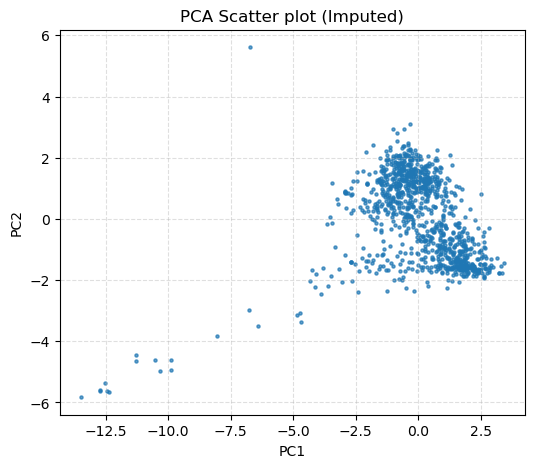

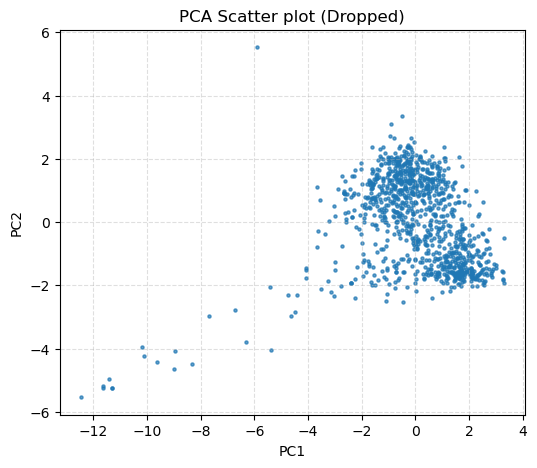

In [48]:
#PCA reduction
def apply_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
    #return data frame and pca model 
    return X_pca_df, pca

#PCA variance plot before clustering
def pca_plot(X_pca_df, tip, labels=None):
    plt.figure(figsize=(6, 5))
    
    if labels is None:
        plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], s=5, alpha=0.7)
    else:
        #encode labels
        le = LabelEncoder()
        labels_enc = le.fit_transform(labels)
        plt.scatter(
            X_pca_df['PC1'], X_pca_df['PC2'], 
            c=labels_enc, cmap='viridis', s=5, alpha=0.8
        )
        
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA Scatter plot ({tip})")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

#imputed
X_imp = df_imp_scaled.drop(columns=['playlist_id'])
X_pca_imp, _ = apply_pca(X_imp, n_components=3)
pca_plot(X_pca_imp, tip="Imputed")

#dropped
X_drop = df_drop_scaled.drop(columns=['playlist_id'])
X_pca_drop, _ = apply_pca(X_drop, n_components=3)
pca_plot(X_pca_drop, tip="Dropped")



#### Clustering 1: K-means and PCA -> K-means

In [99]:
#KMEANS
def run_kmeans(X, k):
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return labels, sil, db, kmeans

#score plot
def plot_scores(results_dict, metric_name="Silhouette Score"):
    ks = list(results_dict.keys())
    scores = [results_dict[k] for k in ks]

    plt.figure(figsize=(6, 5))
    plt.plot(ks, scores, marker='o')
    plt.xlabel("k")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} vs k")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

#centroid heatmap
def plot_centroid_heatmap(centroids, title="Cluster Centroid Heatmap"):
    plt.figure(figsize=(8, 4))
    sns.heatmap(centroids, annot=False, cmap="viridis")
    plt.title(title)
    plt.show()

#cluster summary by genres
def genre_cluster_summary(df_all, labels):

    #select genre columns
    genre_cols = [c for c in df_all.columns if c.startswith("genre_")]
    
    #copy and add cluster labels
    df_tmp = df_all.copy()
    df_tmp['cluster'] = labels
    
    #mean per cluster
    cluster_means = df_tmp.groupby('cluster')[genre_cols].mean()
    
    #remove 'genre_' prefix
    cluster_means.columns = [c.replace('genre_', '') for c in cluster_means.columns]
    
    #keep only top 5 genres per cluster
    top5_dict = {}
    for cluster_id, row in cluster_means.iterrows():
        row_clean = row.dropna()
        top5 = row_clean.nlargest(10)
        top5_dict[cluster_id] = list(top5.items())
    
    return top5_dict


#pipeline
def kmeans_pipeline(X, df_all, k_range=range(3, 11), drop_cols=['playlist_id'], plot_pca=True, pca_data=False):
    
    # run k-means for multiple k
    results_sil = {}
    results_db = {}
    models = {}
    labels_dict = {}
    
    for k in k_range:
        labels, sil, db, model = run_kmeans(X, k)
        results_sil[k] = sil
        results_db[k] = db
        models[k] = model
        labels_dict[k] = labels
    
    # plot silhouette and DB scores
    plot_scores(results_sil, metric_name="Silhouette Score")
    plot_scores(results_db, metric_name="Davies-Bouldin Score")
    
    # pick best k based on silhouette
    best_k = max(results_sil, key=results_sil.get)
    best_labels = labels_dict[best_k]
    best_model = models[best_k]
    print(f"Best k based on silhouette: {best_k}")
    
    # PCA for plotting 
    if plot_pca:
        X_pca_df, _ = apply_pca(X, n_components=2)
        pca_plot(X_pca_df, tip=f"k={best_k}", labels=best_labels)
    
    #centroids
    if pca_data == False:
        centroids = best_model.cluster_centers_    
        centroids_df = pd.DataFrame(centroids, columns=[c for c in X.columns if c != 'playlist_id'])
        plot_centroid_heatmap(centroids_df)
        print(centroids_df)

    #genre summary
    genre_summary = genre_cluster_summary(df_all, best_labels)
    for c, it in genre_summary.items():
        print(f"Cluster {c}:")
        for x in it:
            print(f"{x[0]}, {x[1]:.3f}")
        print()

    # return results
    return {
        "best_k": best_k,
        "best_labels": best_labels,
        "best_model": best_model,
        "silhouette_scores": results_sil,
        "db_scores": results_db,
        "genre_summary": genre_summary
    }


K-means on original feature space:

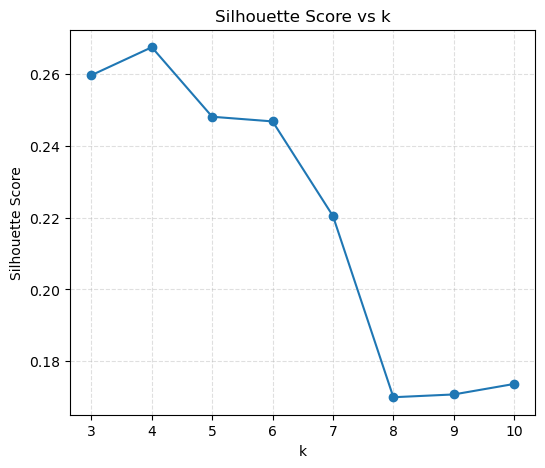

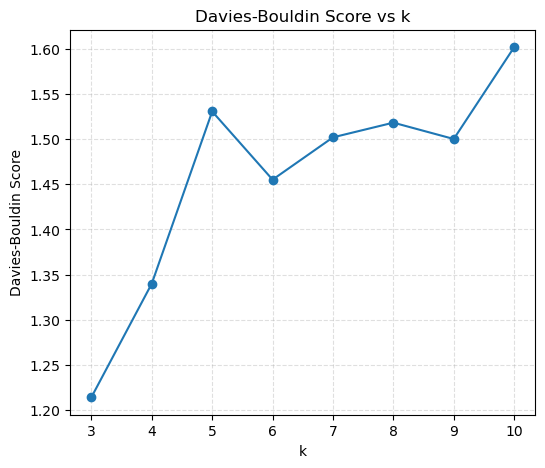

Best k based on silhouette: 4


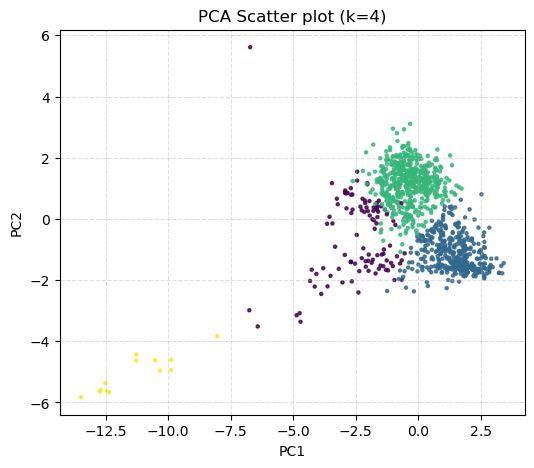

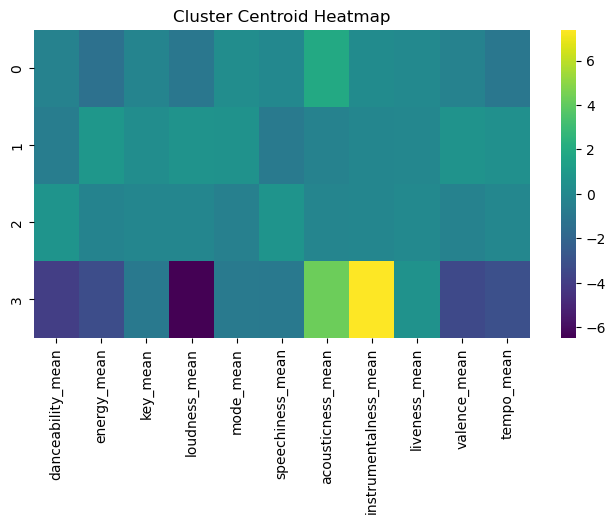

   danceability_mean  energy_mean  key_mean  loudness_mean  mode_mean  \
0          -0.402066    -1.375548 -0.221509      -1.008433   0.274251   
1          -0.646975     0.855923  0.238262       0.626398   0.592058   
2           0.703618    -0.305967 -0.119844      -0.118208  -0.509620   
3          -3.962971    -3.283855 -0.898344      -6.487147  -0.807989   

   speechiness_mean  acousticness_mean  instrumentalness_mean  liveness_mean  \
0         -0.034668           1.874789               0.125073       0.024420   
1         -0.832730          -0.403794              -0.108242      -0.080136   
2          0.694511          -0.185993              -0.130520       0.043601   
3         -0.889755           4.266375               7.377906       0.586673   

   valence_mean  tempo_mean  
0     -0.404984   -0.982285  
1      0.661173    0.421927  
2     -0.352721   -0.048231  
3     -3.437477   -3.092448  
Cluster 0:
pop, 0.184
show-tunes, 0.167
hip-hop, 0.128
acoustic, 0.090
folk, 0.068


In [75]:
#imputed
results_imp = kmeans_pipeline(X_imp, df_imp_all)

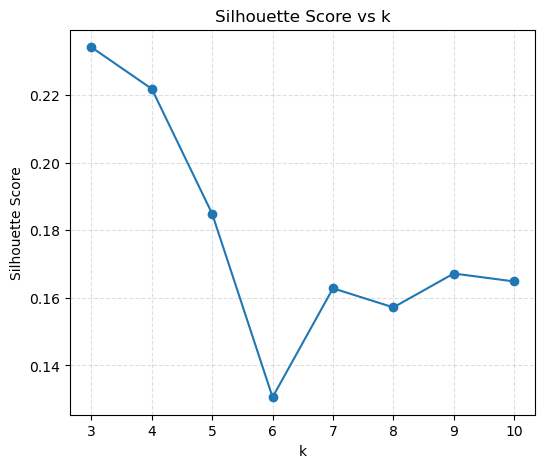

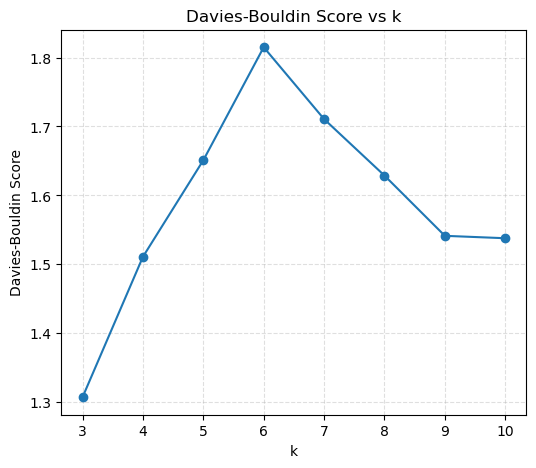

Best k based on silhouette: 3


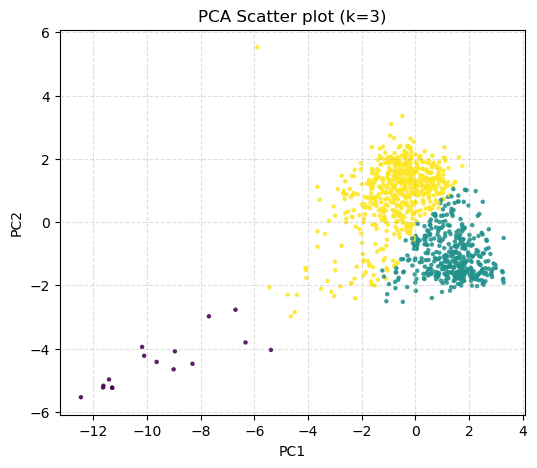

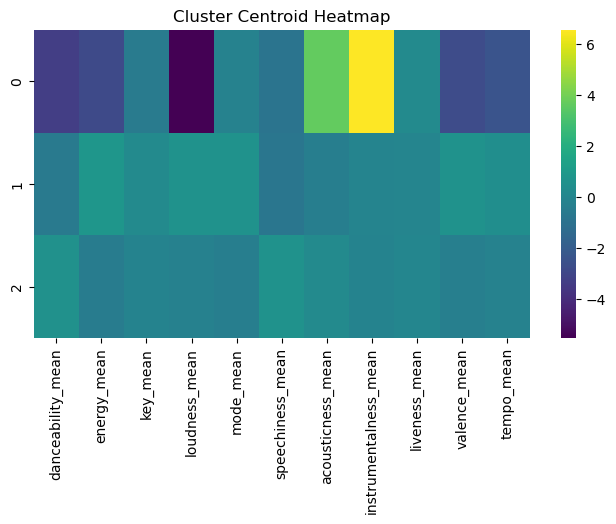

   danceability_mean  energy_mean  key_mean  loudness_mean  mode_mean  \
0          -3.359266    -2.812662 -0.560990      -5.534663  -0.206506   
1          -0.588175     0.814710  0.176201       0.611673   0.567394   
2           0.509799    -0.503687 -0.110218      -0.285336  -0.398307   

   speechiness_mean  acousticness_mean  instrumentalness_mean  liveness_mean  \
0         -0.887654           3.636397               6.547749       0.184981   
1         -0.770749          -0.406246              -0.071988      -0.034718   
2          0.572741           0.190578              -0.126320       0.019698   

   valence_mean  tempo_mean  
0     -2.791383   -2.373751  
1      0.592514    0.380790  
2     -0.346091   -0.206698  
Cluster 0:
classical, 0.411
sleep, 0.231
german, 0.095
folk, 0.067
french, 0.057
electro, 0.031
alt-rock, 0.025
piano, 0.021
new-age, 0.021
metal, 0.017

Cluster 1:
country, 0.430
pop, 0.095
alt-rock, 0.093
dance, 0.091
rock, 0.087
metal, 0.035
hip-hop, 0.034
emo, 0

In [76]:
#dropped
results_drop = kmeans_pipeline(X_drop, df_drop_all)

K-means on PCA-reduced space:

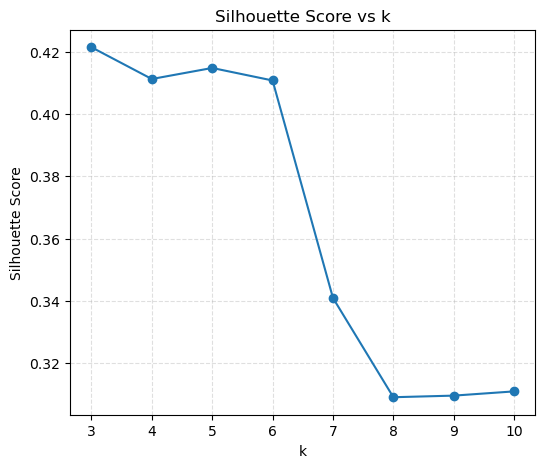

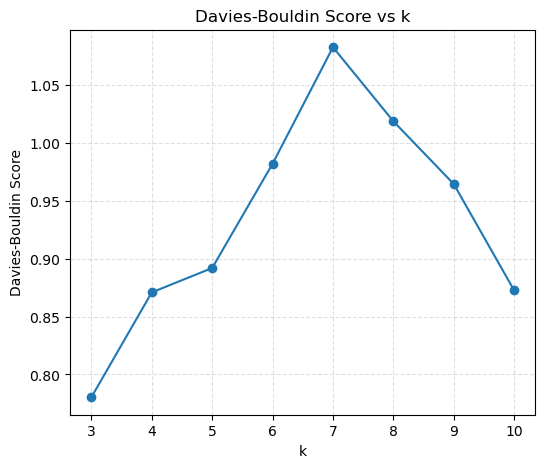

Best k based on silhouette: 3


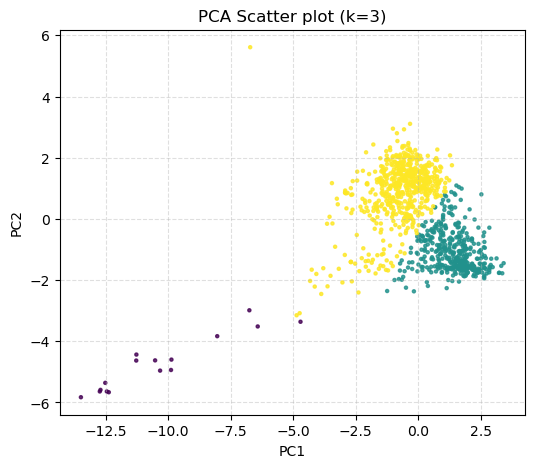

Cluster 1:
classical, 0.415
sleep, 0.235
german, 0.100
folk, 0.065
french, 0.058

Cluster 2:
country, 0.438
pop, 0.098
dance, 0.094
rock, 0.094
alt-rock, 0.093

Cluster 3:
hip-hop, 0.612
dance, 0.088
pop, 0.073
electro, 0.035
show-tunes, 0.030



In [63]:
#imputed
results_imp_pca = kmeans_pipeline(X_pca_imp, df_imp_all, pca_data=True)

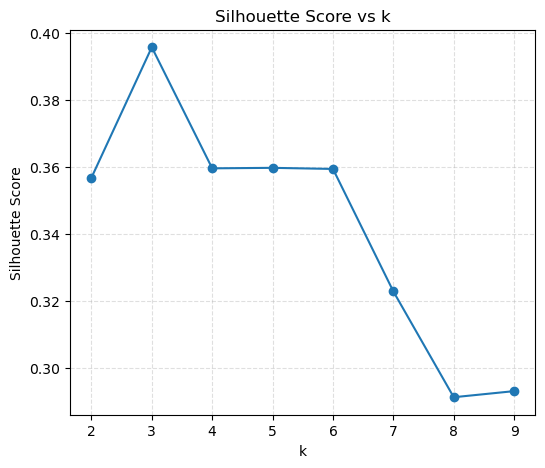

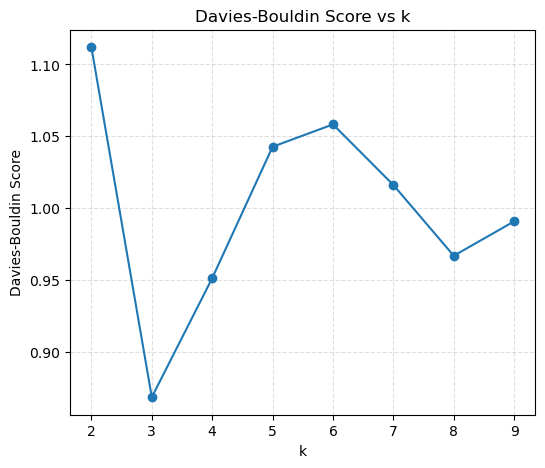

Best k based on silhouette: 3


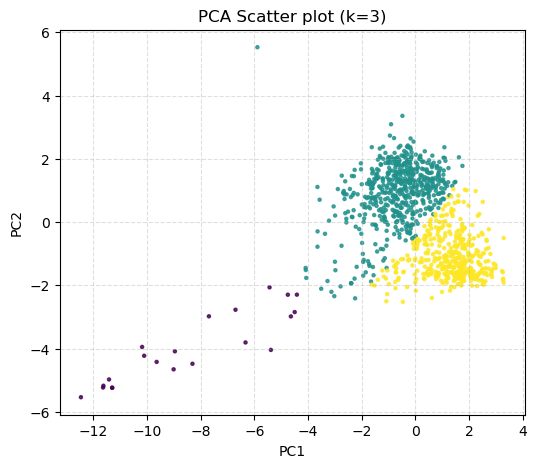

Cluster 1:
classical, 0.313
sleep, 0.176
opera, 0.094
german, 0.072
acoustic, 0.065

Cluster 2:
hip-hop, 0.597
dance, 0.097
pop, 0.080
electro, 0.035
show-tunes, 0.029

Cluster 3:
country, 0.431
pop, 0.097
alt-rock, 0.094
dance, 0.089
rock, 0.087



In [69]:
#dropped
results_drop_pca = kmeans_pipeline(X_pca_drop, df_drop_all, pca_data=True, k_range=range(2, 10))

**Results**


**1. Imputed Audio Features (Full Feature Space)**

(Most expressive but somewhat noisy due to imputation)

The imputed, non-reduced clustering produced four clusters, driven by variation in acousticness, energy, loudness, and instrumentalness.

Cluster A — Mixed Pop / Acoustic / Show-Tunes Hybrid

This cluster shows moderate acousticness and moderate energy but lacks extreme values. Genre distribution includes pop (18.4%), show-tunes (16.7%), hip-hop (12.8%), and a broad mix of acoustic and folk genres. The lack of strong acoustic signatures indicates a heterogeneous, mixed-purpose playlist group, likely blending mainstream pop with lighter acoustic tracks.

Cluster B — Energetic Country–Rock–Pop

This cluster displays high energy, high loudness, and high valence, characteristic of upbeat, amplified music. Genres strongly align with this: country (45.7%), rock (9.7%), alt-rock (9.5%), and dance (8.8%). Playlists in this group appear to represent driving, workout, or festival-style mixes.

Cluster C — Hip-Hop / Dance / Electronic

Characterized by the highest danceability and highest speechiness, this cluster captures playlists dominated by hip-hop (70.2%), with supporting roles from dance (10.2%) and electronic genres. The acoustic profile (low acousticness, moderately loud, rhythmic) matches the trap / rap / club music sound profile.

Cluster D — Classical / Ambient / Fully Instrumental

The most distinct cluster, defined by extremely low danceability, very low energy, very negative loudness, and very high acousticness and instrumentalness. Genre distribution confirms: classical (50.3%), sleep/ambient (28.9%), and piano/new-age music dominate. This cluster represents quiet, instrumental playlists used for studying, relaxing, or background ambience.

Interpretation:
All four clusters are coherent and musically meaningful. However, the mixed nature of Cluster A indicates some noise introduced by imputation, which blurs boundaries between pop/acoustic/hip-hop playlists.

**2. Dropped-NA Audio Features (Full Feature Space)**

(Cleaner structure, fewer playlists, stronger clusters)

When removing tracks with missing audio features, three clear and stable clusters appear.

Cluster 0 — Classical / Ambient / Instrumental

Similar to Cluster D above, this group contains extremely low-energy, quiet, instrumental playlists. Genres confirm: classical (41.1%), sleep (23.1%), folk, French acoustic, and piano/new-age.
This cluster is the most homogeneous across all models.

Cluster 1 — Country / Rock / Pop (High Energy)

The energetic, major-key playlists again form a strong cluster. The dominant genres (country 43.0%, pop, alt-rock, dance) match the audio profile of high-energy and loud modern mainstream music.

Cluster 2 — Hip-Hop / Dance

The danceable, speech-heavy playlists again form a stable cluster dominated by hip-hop (59.0%), dance, pop, and electro. Audio features (high speechiness, high danceability) reinforce this.

Interpretation:
Dropping NA values improves cluster clarity and creates tighter, more musically consistent groups. Compared to the imputed model, no noisy mixed-pop cluster appears; the structure becomes cleaner.

**3 & 4. PCA-Reduced Models (Imputed + Dropped NA)**

(Very clean grouping, but acoustic interpretability limited)

Using PCA to compress audio features into principal components produces three very clean and visually well-separated clusters, but interpretability of centroids decreases because PCA mixes features into abstract linear combinations.
However, the genre composition of each cluster remains extremely stable and matches the non-reduced solutions:

Cluster A — Classical / Ambient / Instrumental\
Cluster B — Country / Rock / Pop\
Cluster C — Hip-Hop / Dance / Electronic

These clusters replicate the three dominant archetypes found previously, confirming that the structure is not dependent on missing values or high dimensionality.

Interpretation:
The PCA clustering is visually the cleanest and most balanced. However, it sacrifices the ability to explain clusters directly in terms of audio features, which weakens interpretability.



| Model               | Clarity  | Interpretability | Stability | Comments                                   |
| ------------------- | -------- | ---------------- | --------- | ------------------------------------------ |
| Imputed (no PCA)    | Medium   | High             | OK        | 4 clusters but one is noisy/mixed          |
| Dropped NA (no PCA) | **High** | **High**         | **High**  | Best balance of clarity + interpretability |
| Imputed PCA         | High     | Low              | Medium    | Clean, but audio meaning lost              |
| Dropped PCA         | High     | Low              | High      | Best visually; weak interpretability       |


#### Clustering 2: Hierarchical clustering

I chose agglomerative clustering for the next option because it does not require a predefined number of clusters and builds a gull clustering tree which allows us to inspect the structure of the data, see natural separations and choose number of clusters after that. Valuable, since playlist audio distributions do not form obvious clusters.

Our final similarity matrix of 1026 playlists is also small enough for this to be computationally feasible.

DBSCAN in this case would not work very well, because our clusters are continuous and overlapping and there is no individual dense blobs, only one continuous blob and large empty regions. Interpreting the clusters would also be very difficult.

In [95]:
def hierarchical_clustering(X):
    # linkage: how clusters merge. 'ward' works best for numeric, scaled data
    Z = linkage(X, method='ward')

    plt.figure(figsize=(14, 6))
    plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
    plt.xlabel("Playlist index")
    plt.ylabel("Distance")
    dendrogram(Z, truncate_mode='level', p=6)  # shows only the top merges for clarity
    plt.show()

def plot_pca_agg(X, n_clusters):
    agg = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage='ward'
    )

    clusters_agg = agg.fit_predict(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    for cluster_id in sorted(set(clusters_agg)):
        mask = clusters_agg == cluster_id
        plt.scatter(
            X_pca[mask, 0],
            X_pca[mask, 1],
            s=20,
            label=f"Cluster {cluster_id}"
        )
    plt.title("Agglomerative Clustering (PCA 2D projection)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    #plt.legend(title="Cluster")
    plt.show()

Imputed:

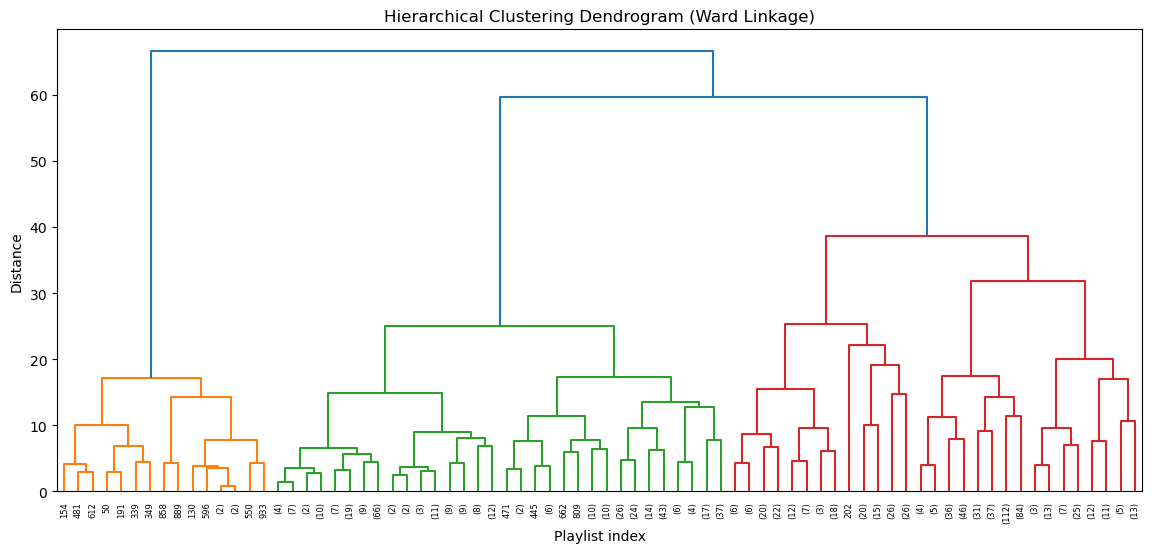

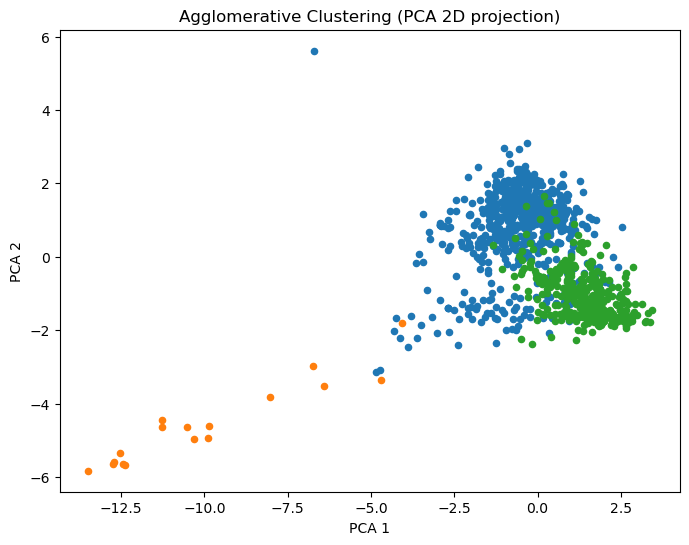

In [97]:
hierarchical_clustering(X_imp)
plot_pca_agg(X_imp, 3)

Dropped NAs:

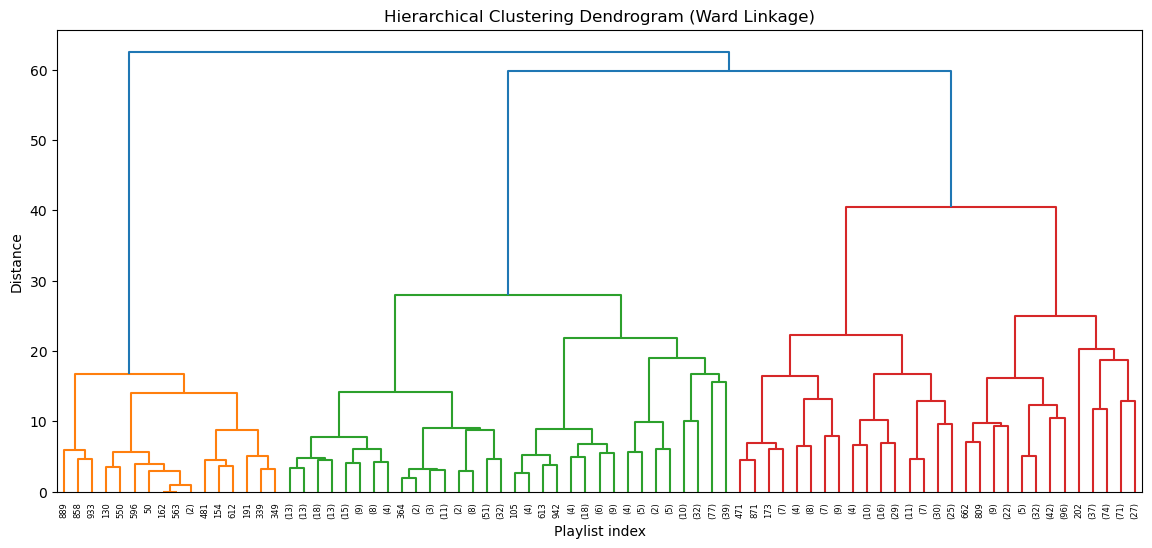

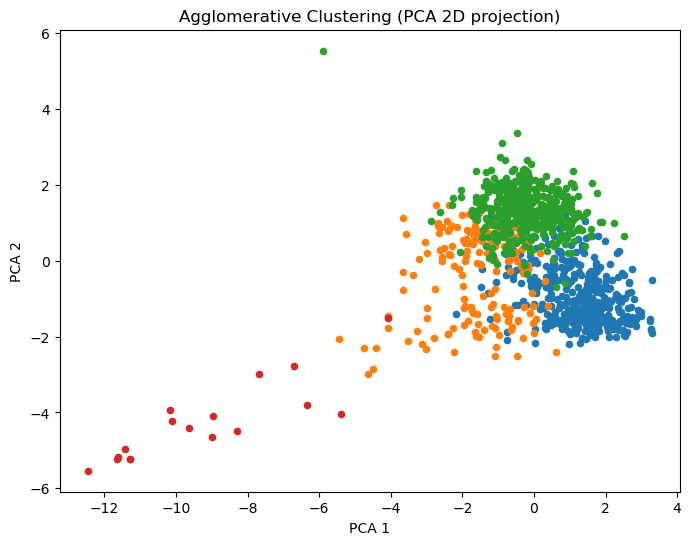

In [98]:
hierarchical_clustering(X_drop)
plot_pca_agg(X_drop, 4)

This type of clustering is by itself not very interpretable, and it was more used to check about the choice of K. It yields results that agree on K-means and the clusters seem to be pretty much the same, even though K-means shows less overlap. Dendrogram shows that best K is either 3 or 4.

#### Clustering 3: DBSCAN (failed)

Imputed:


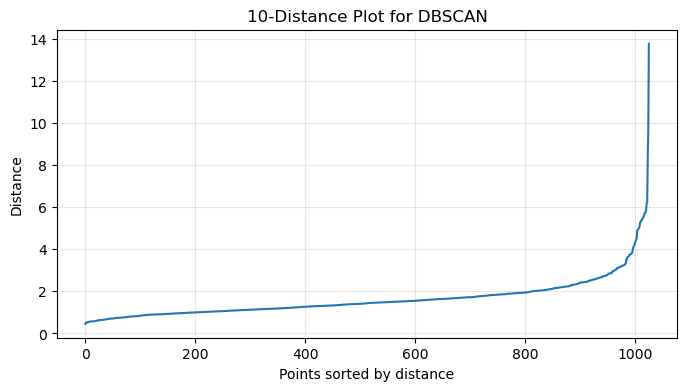

Dropped NAs:


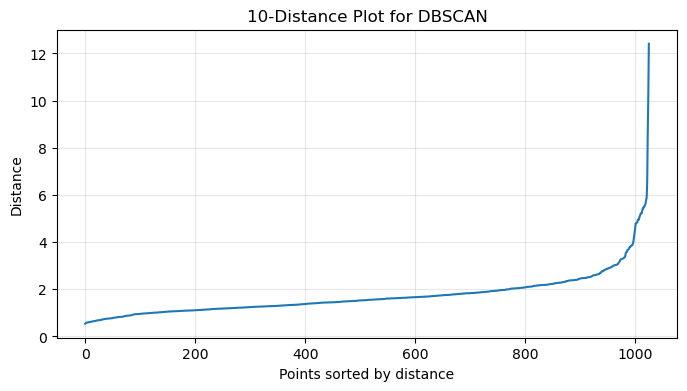

In [110]:
def plot_k_distance(X, k=10):
   
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    
    # take the k-th distance, sort
    k_distances = np.sort(distances[:, -1])
    
    plt.figure(figsize=(8,4))
    plt.plot(k_distances)
    plt.title(f"{k}-Distance Plot for DBSCAN")
    plt.xlabel("Points sorted by distance")
    plt.ylabel("Distance")
    plt.grid(True, alpha=0.3)
    plt.show()

    return k_distances

print("Imputed:")
_ = plot_k_distance(X_imp)
print("Dropped NAs:")
_ = plot_k_distance(X_drop)

eps chosen at elbow: 2.5

Very high, DBSCAN is probably not going to work.

In [121]:
def run_dbscan(X, eps, min_samples=10):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = sum(labels == -1)
    
    print(f"DBSCAN found {n_clusters} clusters + {n_noise} noise points")
    
    return labels, db

eps = 2.5
labels_imp, db_imp = run_dbscan(X_imp, eps)
labels_drop, db_drop = run_dbscan(X_drop, eps)

DBSCAN found 1 clusters + 47 noise points
DBSCAN found 1 clusters + 56 noise points


DBSCAN does not work with this data set, further testing and analysis with this is pointless.

### 2.2 Genre-based clustering

Data preparation:

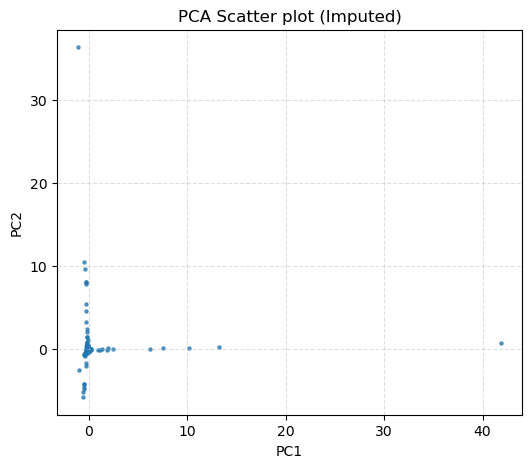

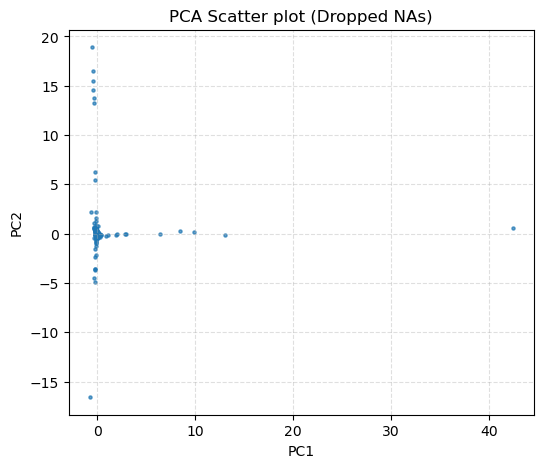

In [132]:
#select columns
df_imp_genre = df_imp_all[genre_cols]
df_drop_genre = df_drop_all[genre_cols]

#scaling
df_imp_gsc = scale_features(df_imp_genre, genre_cols)
df_drop_gsc = scale_features(df_drop_genre, genre_cols)

#PCA
df_imp_gpca, _ = apply_pca(df_imp_gsc, n_components=0.90)
df_drop_gpca, _ = apply_pca(df_drop_gsc, n_components=0.90)

#visualisation
pca_plot(df_imp_gpca, "Imputed")
pca_plot(df_drop_gpca, "Dropped NAs")



The matrix is very sparse and that's why my PCA plots look like this but maybe it will get better.

K-Means:

In [154]:
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

def plot_pca_3d(X, labels, title="PCA 3D Projection"):

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        X_pca[:,0], X_pca[:,1], X_pca[:,2],
        c=labels, cmap='tab10', s=20, alpha=0.8
    )
    
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(title)
    
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    
    plt.show()



def genre_kmeans_pipeline(X_genre, df_all, k_range=[3,4,5,6,7], best_k=None, top_n=5, plot_umap=True, plot_heatmap=True, random_state=42):
    
    results_sil = {}
    results_db = {}
    models = {}
    labels_dict = {}
    
    print("Running KMeans for multiple k:")
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state)
        labels = km.fit_predict(X_genre)
        sil = silhouette_score(X_genre, labels)
        db = davies_bouldin_score(X_genre, labels)
        
        results_sil[k] = sil
        results_db[k] = db
        models[k] = km
        labels_dict[k] = labels
        
        print(f"k={k}, silhouette={sil:.4f}, DB={db:.4f}")
    print()
    
    #best_k
    if best_k is None:
        best_k = max(results_sil, key=results_sil.get)
    print(f"Selected best_k = {best_k}")
    
    #best model
    best_model = models[best_k]
    best_labels = labels_dict[best_k]
    
    #cluster labels to dataframe
    df_all = df_all.copy()
    df_all['cluster_genre'] = best_labels
    
    #cluster sizes
    unique, counts = np.unique(best_labels, return_counts=True)
    print("\nCluster sizes:")
    for u, c in zip(unique, counts):
        print(f"Cluster {u+1}: {c} items")
    
    #summary / centroids
    cluster_summary = df_all.groupby('cluster_genre').mean()
    
    #dominant genres per cluster
    for cluster_id, row in cluster_summary.iterrows():
        print(f"\n=== Cluster {cluster_id+1} ===")
        non_zero_genres = row[row > 0]
        if non_zero_genres.empty:
            print("No genres present.")
            continue
        top_genres = non_zero_genres.sort_values(ascending=False).head(top_n)
        for genre, val in top_genres.items():
            print(f"{genre.replace('genre_', ''):20s} {val:.3f}")

    #pca plot
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X_genre)
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=df_all['cluster_genre'], cmap='tab10', s=10)
    plt.title(f"PCA 2D Projection of Genre Clusters (k={best_k})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    plot_pca_3d(X_genre, df_all['cluster_genre'])
    
    #centroid heatmap
    if plot_heatmap:
        plt.figure(figsize=(10,6))
        sns.heatmap(cluster_summary, annot=False, cmap="viridis")
        plt.title(f"Cluster Centroid Heatmap (k={best_k})")
        plt.xlabel("Genres")
        plt.ylabel("Cluster")
        plt.show()
    
    #UMAP visualization
    if plot_umap:
        reducer = umap.UMAP(random_state=random_state, init="random")
        embedding = reducer.fit_transform(X_genre)
        plt.figure(figsize=(7,5))
        plt.scatter(embedding[:,0], embedding[:,1], c=df_all['cluster_genre'], cmap='tab10', s=10)
        plt.title("UMAP Genre Clusters")
        plt.show()
    
    return {
        "best_k": best_k,
        "model": best_model,
        "labels": best_labels,
        "silhouette_scores": results_sil,
        "db_scores": results_db,
        "cluster_summary": cluster_summary
    }


Running KMeans for multiple k:
k=3, silhouette=0.5226, DB=1.0064
k=4, silhouette=0.5477, DB=1.0168
k=5, silhouette=0.5758, DB=1.0787
k=6, silhouette=0.6057, DB=1.1732
k=7, silhouette=0.6032, DB=1.3496

Selected best_k = 4

Cluster sizes:
Cluster 1: 370 items
Cluster 2: 191 items
Cluster 3: 44 items
Cluster 4: 421 items

=== Cluster 1 ===
pop                  0.183
dance                0.181
rock                 0.113
electro              0.065
show-tunes           0.048

=== Cluster 2 ===
country              0.956
rock                 0.015
pop                  0.012
dance                0.007
hip-hop              0.003

=== Cluster 3 ===
alt-rock             0.847
rock                 0.030
metal                0.023
dance                0.019
pop                  0.009

=== Cluster 4 ===
hip-hop              0.849
dance                0.054
pop                  0.032
house                0.012
emo                  0.007


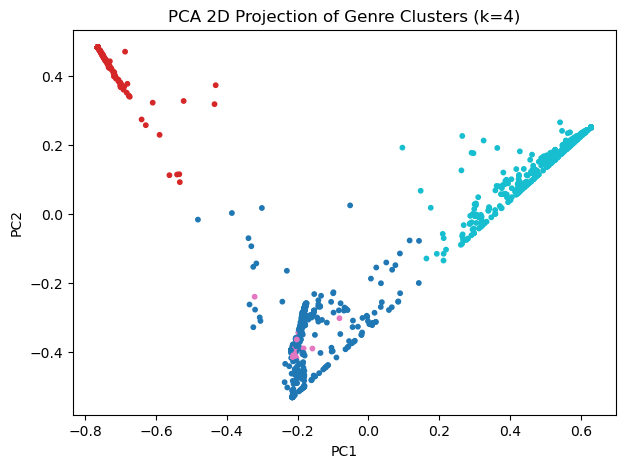

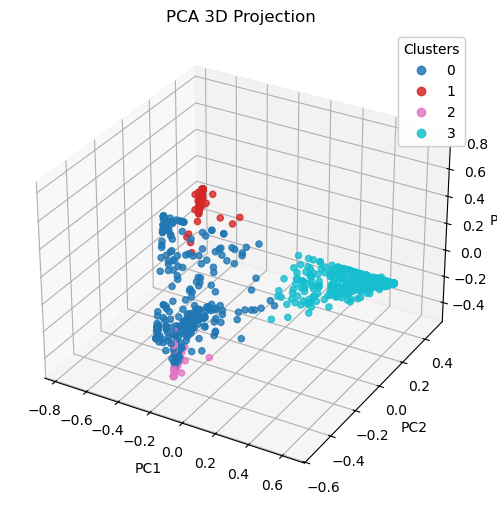

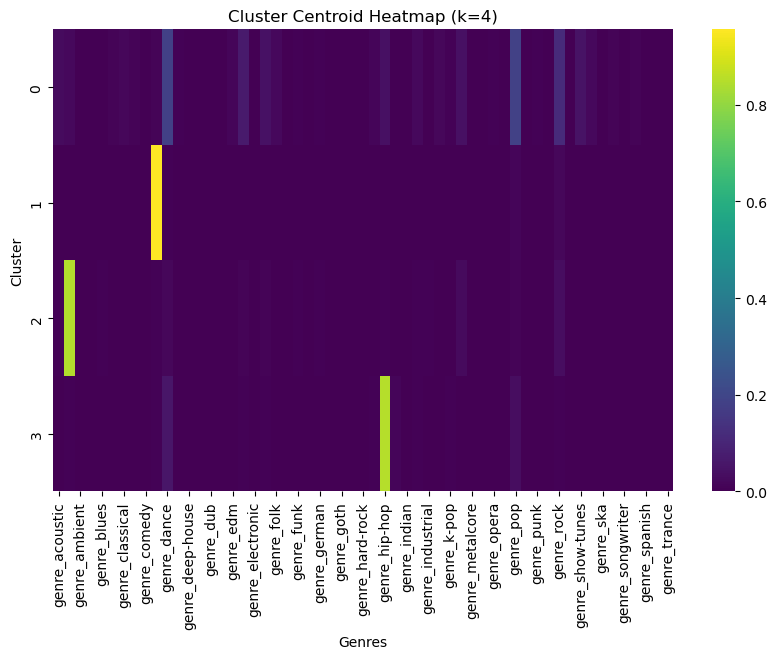

c:\Users\lunka\miniforge3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


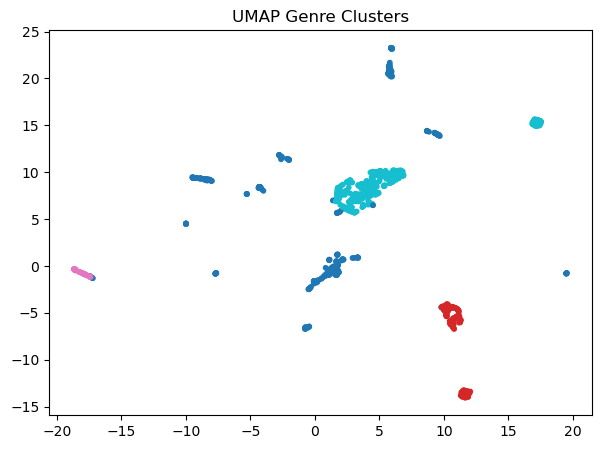

In [155]:
results_genre_imp = genre_kmeans_pipeline(df_imp_genre, df_imp_genre, best_k=4)

Running KMeans for multiple k:
k=3, silhouette=0.3677, DB=1.1275
k=4, silhouette=0.4910, DB=1.0448
k=5, silhouette=0.5126, DB=1.0380
k=6, silhouette=0.5352, DB=1.1027
k=7, silhouette=0.5540, DB=1.1285

Selected best_k = 4

Cluster sizes:
Cluster 1: 403 items
Cluster 2: 412 items
Cluster 3: 22 items
Cluster 4: 189 items

=== Cluster 1 ===
pop                  0.176
dance                0.162
alt-rock             0.112
rock                 0.103
electro              0.063

=== Cluster 2 ===
hip-hop              0.822
dance                0.065
pop                  0.035
house                0.016
emo                  0.010

=== Cluster 3 ===
show-tunes           0.765
jazz                 0.067
pop                  0.055
rock                 0.052
hip-hop              0.039

=== Cluster 4 ===
country              0.951
rock                 0.019
pop                  0.012
dance                0.007
hip-hop              0.004


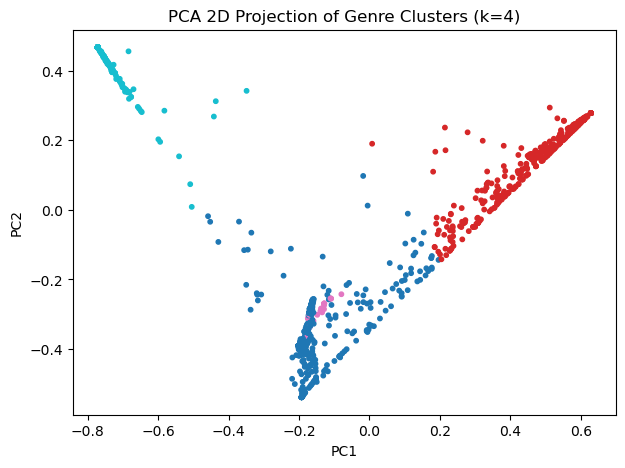

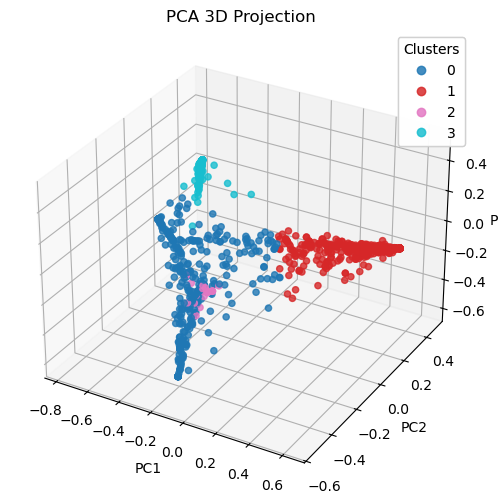

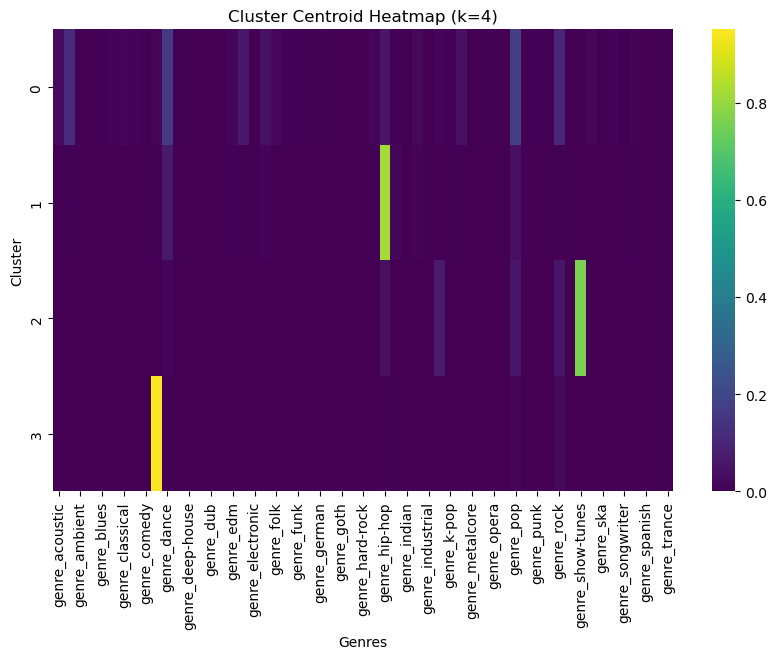

c:\Users\lunka\miniforge3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


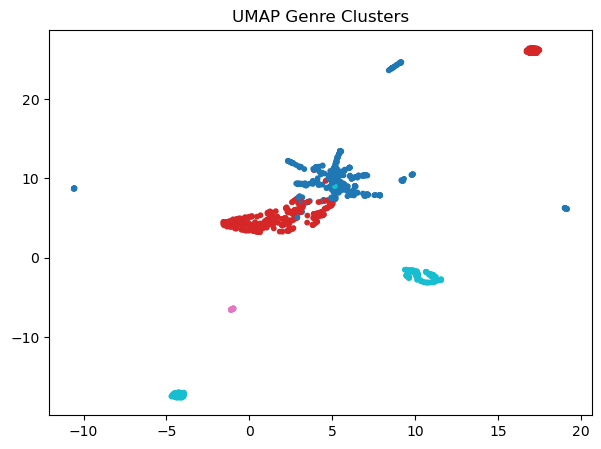

In [156]:
results_genre_drop = genre_kmeans_pipeline(df_drop_genre, df_drop_genre, best_k=4)

Comparing the two KMeans runs, both selected best_k = 4, but the clusters differ in structure and cohesion. In the first run, silhouette scores were generally higher (up to 0.6057), indicating tighter, more well-separated clusters, while the second run had lower silhouette scores (up to 0.5540), suggesting slightly less distinct separation.

The cluster sizes also differ: the first run had a small alternative rock cluster (44 playlists) and a moderate country cluster (191), whereas in the second run, the country cluster became larger (189), the pop cluster expanded (403), and a small show-tunes/jazz cluster emerged (22 playlists).

Looking at dominant genres, the first run’s clusters were clearer in thematic separation:

Cluster 1: pop/dance/rock

Cluster 2: country

Cluster 3: alt-rock/rock

Cluster 4: hip-hop

In the second run, clusters mix some genres more:

Cluster 1: pop/dance/alt-rock/rock

Cluster 2: hip-hop/dance/pop

Cluster 3: show-tunes/jazz

Cluster 4: country

Overall, the first clustering appears more interpretable with distinct genre focus per cluster, while the second clustering produces slightly more mixed clusters but captures niche genres like show-tunes and jazz. Depending on the application—recommendation vs. exploration—the first run may provide cleaner genre-based separation, while the second run may highlight minor niche clusters.

### 2.3 Text-based clustering (playlist name)

Data load:

In [ ]:
df_text = pd.read_csv("data/data_text.csv")
df_text = df_text[['playlist_id', 'playlist_name']]

TD-IDF and K-means:

In [161]:
#TF-IDF: names to vectors
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=3000,        
    ngram_range=(1,2)          
)

X_tfidf = vectorizer.fit_transform(df_text['playlist_name'])


#KMEANS
sil_scores = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=1234)
    labels = km.fit_predict(X_tfidf)
    sil = silhouette_score(X_tfidf, labels)
    sil_scores[k] = sil
    print(k, sil)

2 0.028665219921317514
3 0.08934558366174312
4 0.09349415937822624
5 0.09805366547428356
6 0.11403078577060428
7 0.14030161789017695
8 0.1901329291335556
9 0.20421060359327792


Interpretation of different ks:\
It cannot really be chosen by score, because it will keep increasing as I increase k, so I am focusing more on impretablity.\
Big improvement from 3 to 5, very small changes from 5 to 6 and then probably overfitting. K's bigger than 6 would probably make too specific clusters and they would capture a lot of noise and meaningless words.


In [162]:
#terms ranked by importance for the 4 considered ks
for k_try in [3, 4, 5, 6]:
    km = KMeans(n_clusters=k_try, random_state=1234)
    labels = km.fit_predict(X_tfidf)
    centers = km.cluster_centers_
    terms = vectorizer.get_feature_names_out()

    print(f"\nk={k_try}")
    for i in range(k_try):
        top = centers[i].argsort()[::-1][:8]
        print(f"Cluster {i}: {[terms[j] for j in top]}")


k=3
Cluster 0: ['pop', 'hop', 'hip', 'hip hop', 'rock', 'det', 'det fandme', 'fandme']
Cluster 1: ['music', 'country music', 'country', 'hip hop', 'hip', 'hop', 'good music', 'good']
Cluster 2: ['country', 'new country', 'new', 'øne piløts', 'fetty wap', 'frank ocean', 'frank', 'football pump']

k=4
Cluster 0: ['pop', 'hop', 'hip', 'hip hop', 'rock', 'fandme', 'det', 'det fandme']
Cluster 1: ['music', 'country music', 'country', 'hip hop', 'hip', 'hop', 'good music', 'good']
Cluster 2: ['country', 'new country', 'new', 'øne piløts', 'fetty wap', 'frank ocean', 'frank', 'football pump']
Cluster 3: ['drizzy', 'øne piløts', 'friday', 'freestyle', 'frank ocean', 'frank', 'football pump', 'football']

k=5
Cluster 0: ['pop', 'hop', 'hip', 'hip hop', 'rock', 'det', 'fandme', 'det fandme']
Cluster 1: ['music', 'country music', 'country', 'hip hop', 'hip', 'hop', 'good music', 'good']
Cluster 2: ['country', 'new country', 'new', 'øne piløts', 'fetty wap', 'frank ocean', 'frank', 'football pump

In [163]:
#FINAL MODEL ON K = 5

km_5 = KMeans(n_clusters=5, random_state=1234)
labels = km_5.fit_predict(X_tfidf)
centers = km_5.cluster_centers_
terms = vectorizer.get_feature_names_out()

unique, counts = np.unique(labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u+1}: {c} items")

Cluster 1: 38421 items
Cluster 2: 1681 items
Cluster 3: 3615 items
Cluster 4: 181 items
Cluster 5: 199 items


Visualization:

Text(0.5, 1.0, 'Clusters after t-SNE')

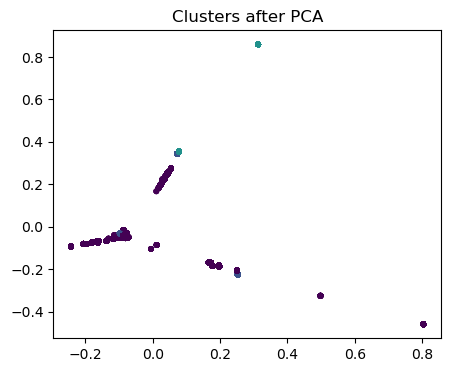

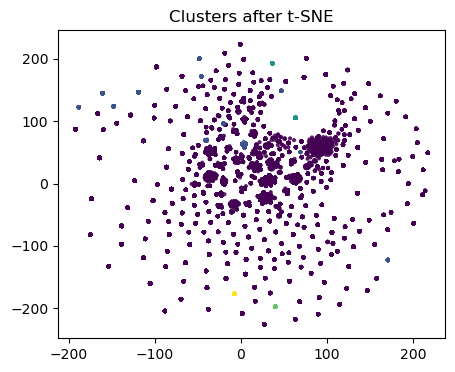

In [164]:
#dimensionality reduction
pca = PCA(n_components=0.90, random_state=1234)
X_pca = pca.fit_transform(X_tfidf.toarray())

tsne = TSNE(n_components=2, perplexity=30, random_state=1234)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(5, 4))
scatter = plt.scatter(
    X_pca[:, 1],
    X_pca[:, 0],
    c=labels,
    cmap="viridis",
    s=10,
    alpha=0.8
)
plt.title("Clusters after PCA")

plt.figure(figsize=(5, 4))
scatter = plt.scatter(
    X_tsne[:, 1],
    X_tsne[:, 0],
    c=labels,
    cmap="viridis",
    s=4,
    alpha=0.8
)
plt.title("Clusters after t-SNE")

Clusters are highly imbalanced as cluster 2 contains more than 80% of all playlists. Playlist titles are too short and random/uninformative and are not useful for genre separation or recommendation. In the visualisations it is also clear that clustering was very unsuccessful.